In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline  

import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

sys.path.append('..')
from utils import *
from data import *
from plotting import *

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 0
# mpl.rcParams['figure.dpi']= 100

sns.set(style='ticks')
sns.set_palette('cubehelix')

In [4]:
kids_x_sdss = process_kids('/media/snakoneczny/data/KiDS/DR4/KiDS.DR4.x.SDSS.DR14.fits', sdss_cleaning=True)

Data shape: (152244, 47)
Droping NANs: 130777 (85.90%) left
Removing errors bigger than 1: 129111 (84.81%) left
Removing GAAP flags: 129111 left
Removing IMA flags: 128675 (84.52%) left
Cleaning SDSS: 121323 left


In [5]:
kids = process_kids('/media/snakoneczny/data/KiDS/DR4/KiDS.DR4.500k.fits')

Data shape: (501754, 42)
Droping NANs: 226903 (45.22%) left
Removing errors bigger than 1: 167995 (33.48%) left
Removing GAAP flags: 167995 left
Removing IMA flags: 167886 (33.46%) left


In [6]:
def add_cut_label(data):
    data['cut_label'] = 'remaining'
    data.loc[data[get_mag_str('r')] > 22, 'cut_label'] = 'r > 22'
    data.loc[data[get_mag_str('r')] > 23, 'cut_label'] = 'r > 23'
    data.loc[data[get_mag_str('r')] > 24, 'cut_label'] = 'r > 24'
    return data

In [7]:
kids_merged = kids.append(kids_x_sdss.loc[~kids['ID'].isin(kids_x_sdss['ID'])], sort=False)
kids_merged = add_cut_label(kids_merged)
kids_merged['is_in_SDSS'] = kids_merged['ID'].isin(kids_x_sdss['ID'])
kids_merged['CLASS'] = kids_merged['CLASS'].fillna(value='not SDSS')

# Data amount vs maximum magnitude

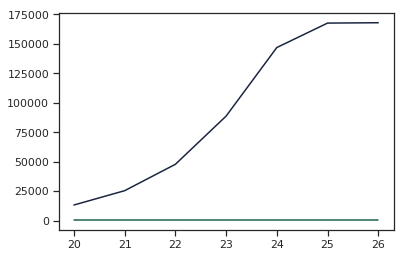

In [8]:
# Data cuts
r_max = kids[get_mag_str('r')].max()
size_max = kids.shape[0]
x = range(20, int(r_max) + 1, 1)
y = [kids.loc[kids[get_mag_str('r')] < r_m].shape for r_m in range(20, int(r_max) + 1, 1)]
plt.plot(x, y)

# KiDS and SDSS feature histograms

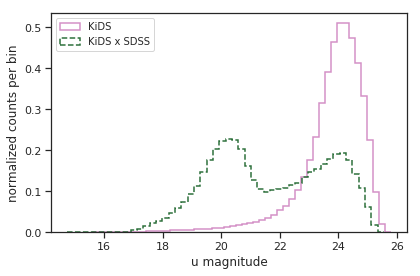

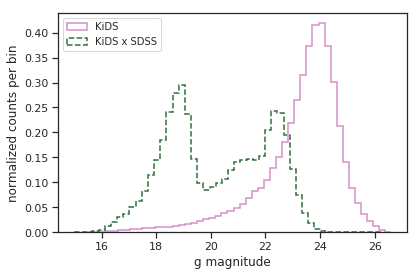

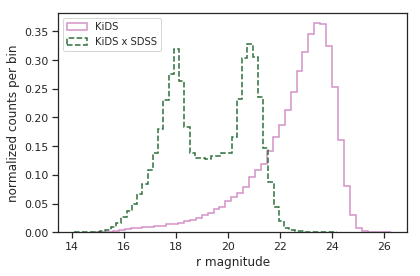

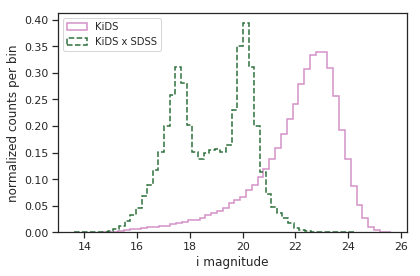

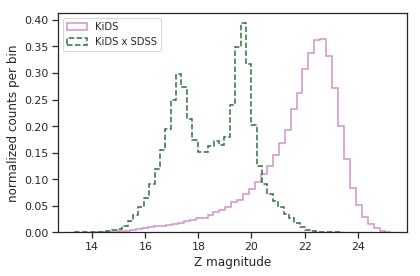

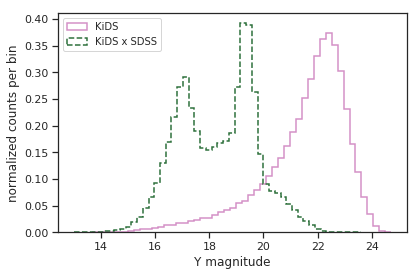

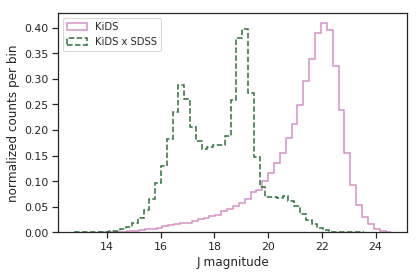

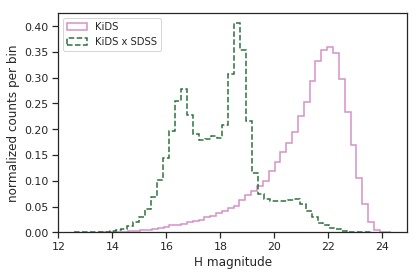

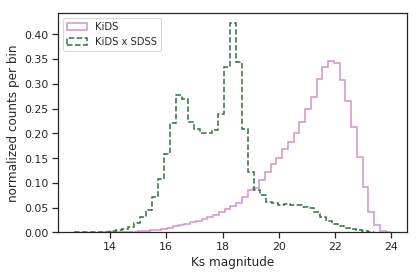

In [13]:
# Magnitude histograms
data_dict = OrderedDict([('KiDS', kids), ('KiDS x SDSS', kids_x_sdss)])
plot_histograms(data_dict, BAND_COLUMNS, legend_size=10, pretty_print_function=pretty_print_feature)

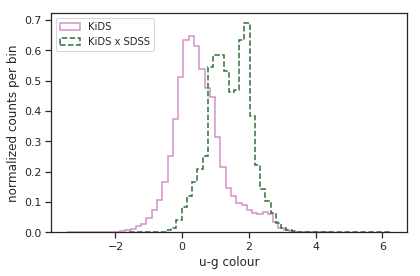

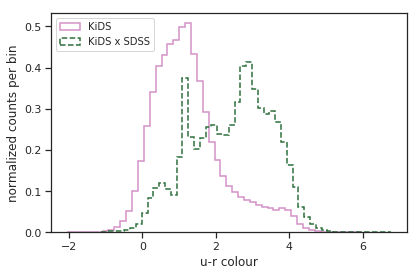

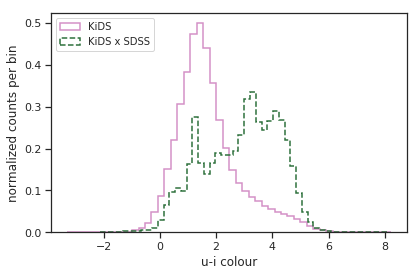

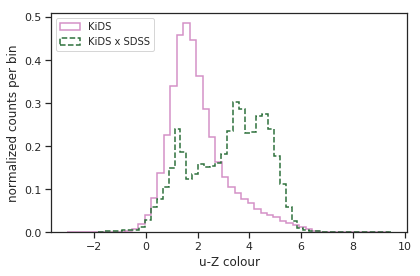

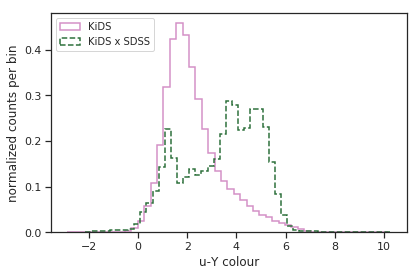

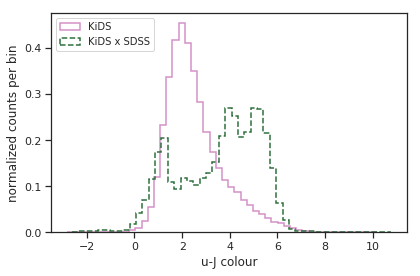

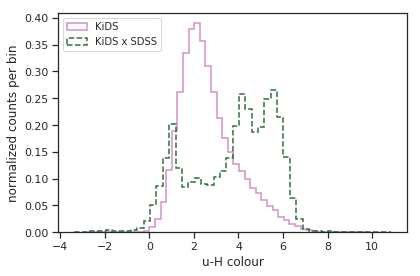

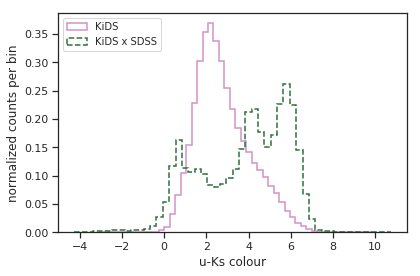

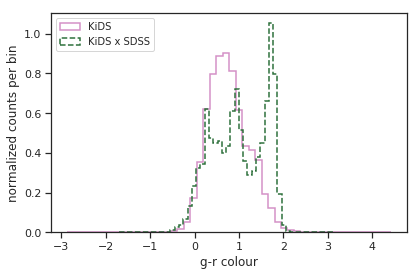

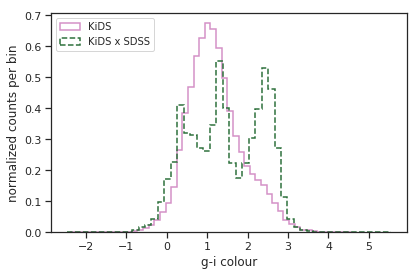

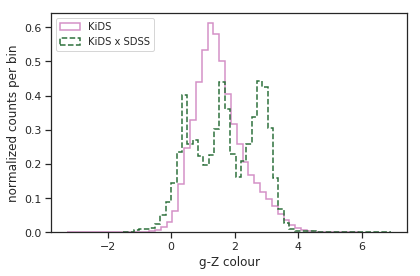

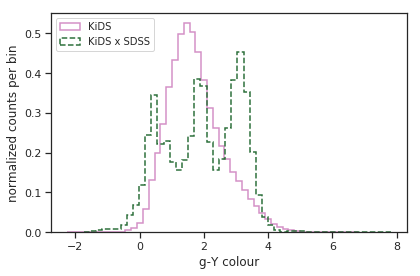

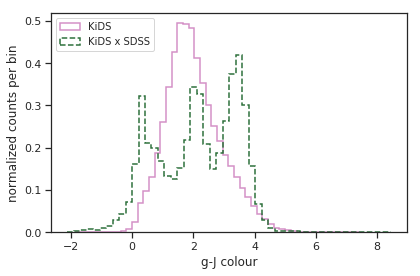

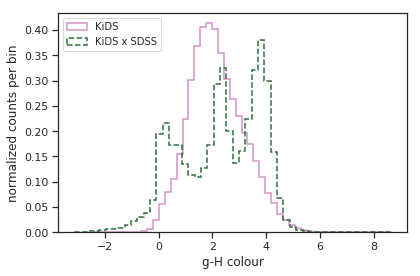

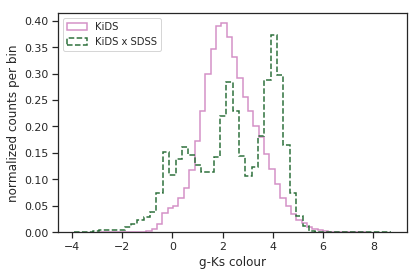

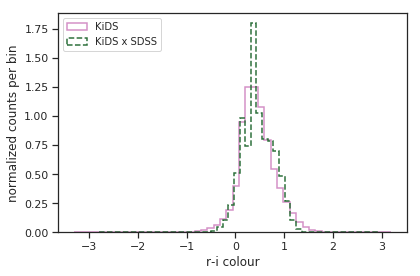

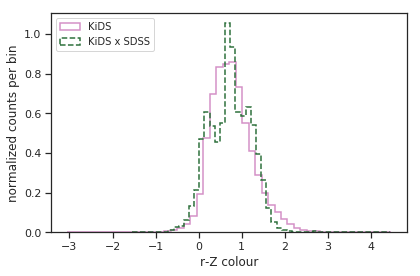

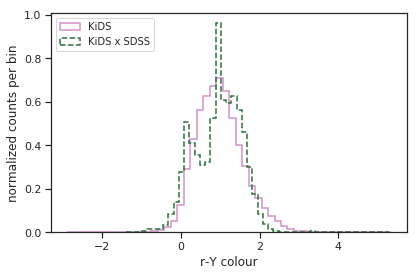

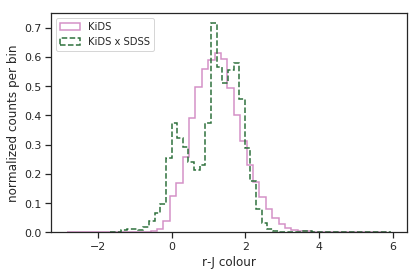

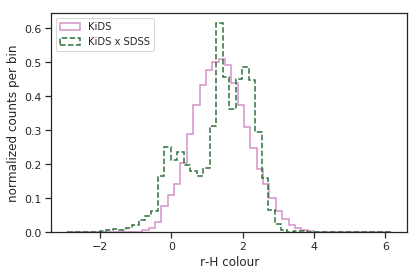

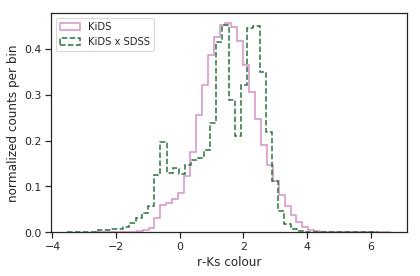

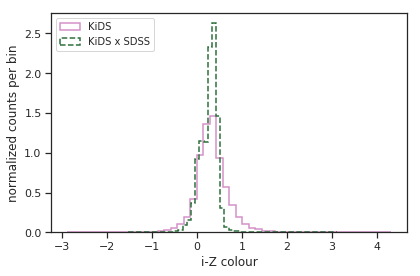

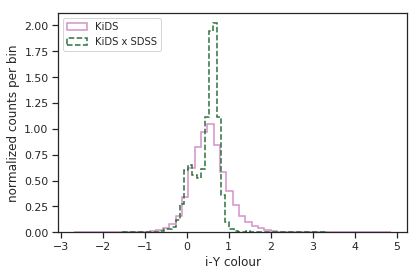

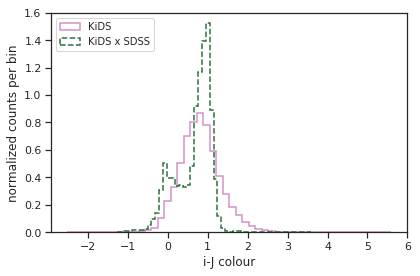

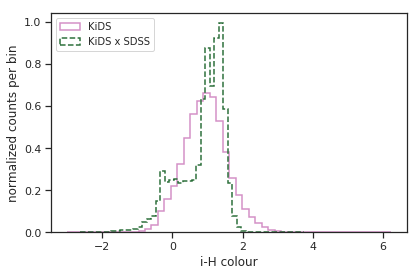

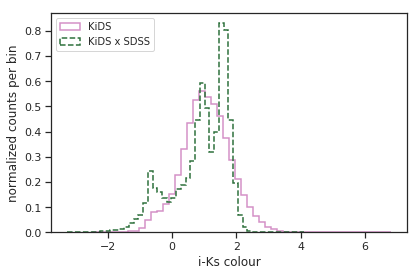

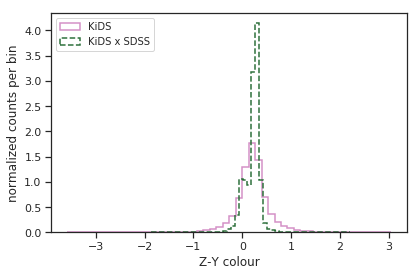

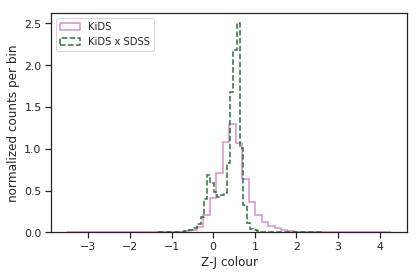

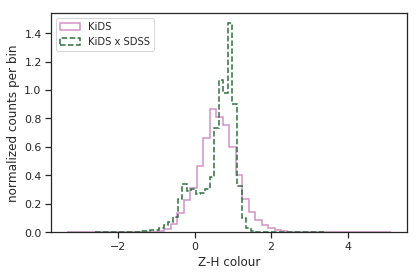

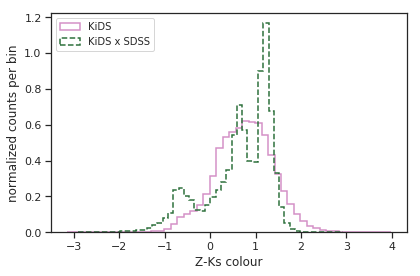

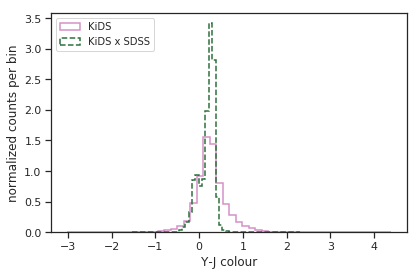

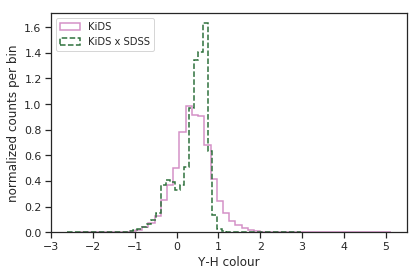

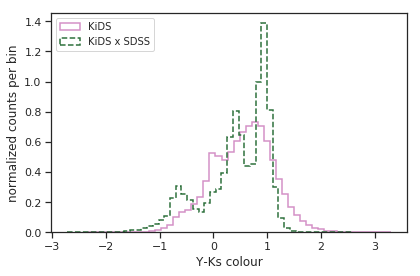

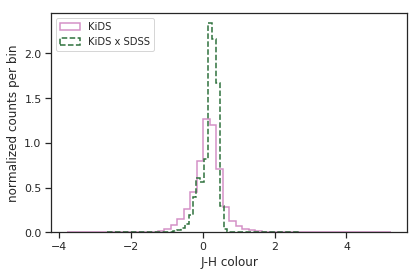

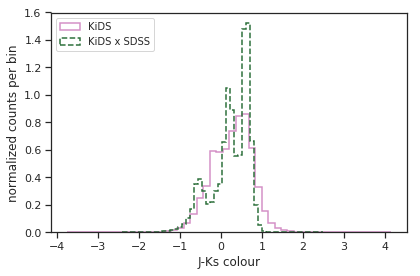

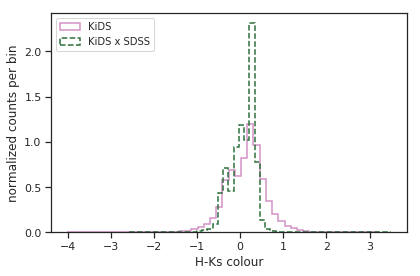

In [14]:
# Color histograms
data_dict = OrderedDict([('KiDS', kids), ('KiDS x SDSS', kids_x_sdss)])
#x_lim_dict = {COLOR_GAAP_STR.format('u', 'g'': (-2, 4)}
plot_histograms(data_dict, COLOR_COLUMNS, legend_size=10, pretty_print_function=pretty_print_feature)

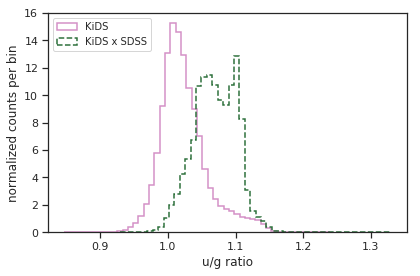

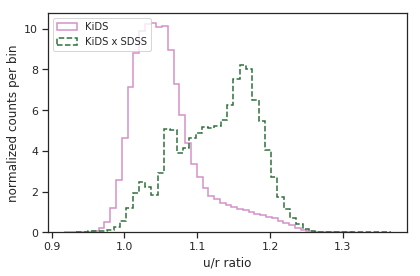

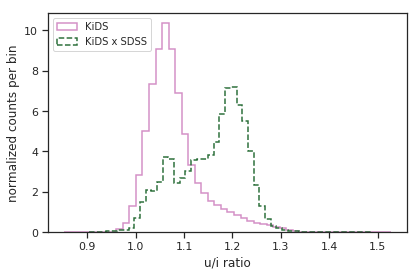

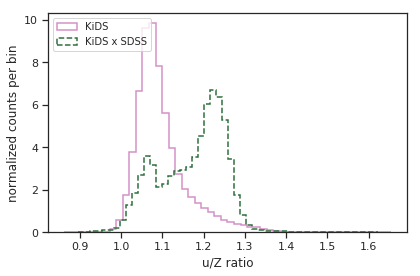

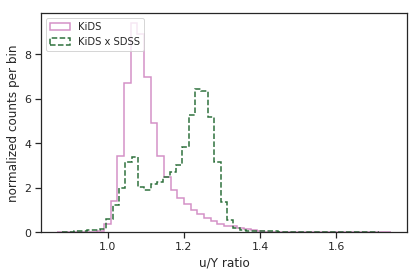

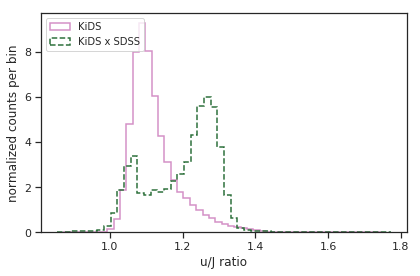

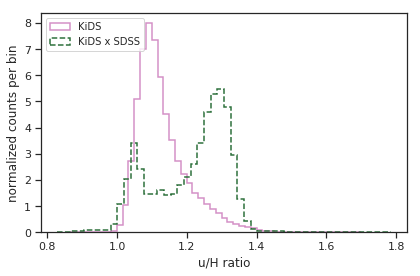

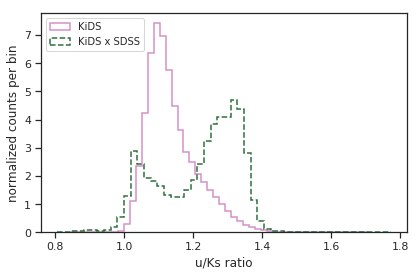

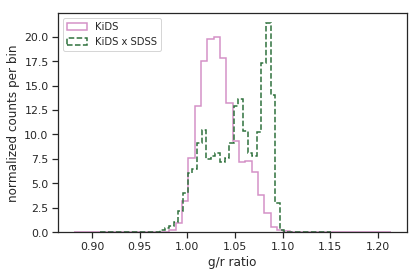

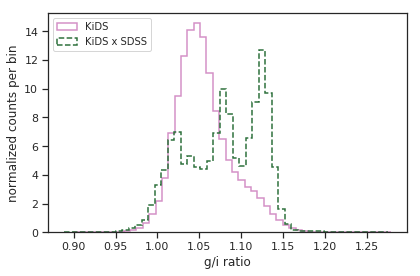

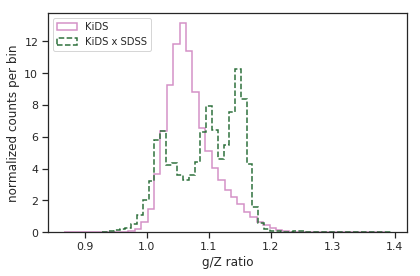

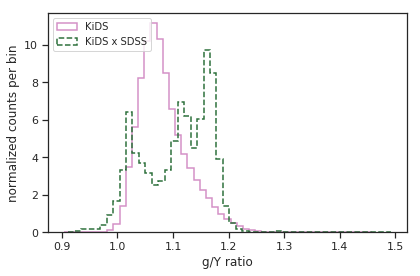

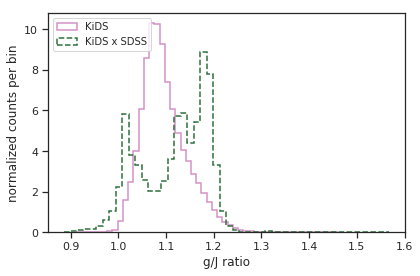

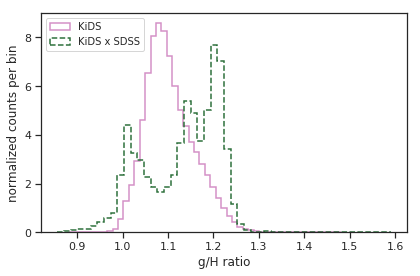

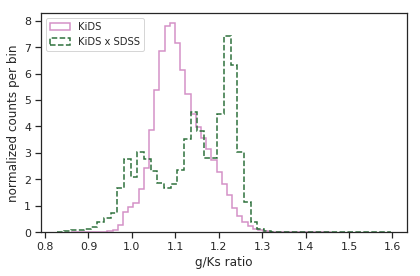

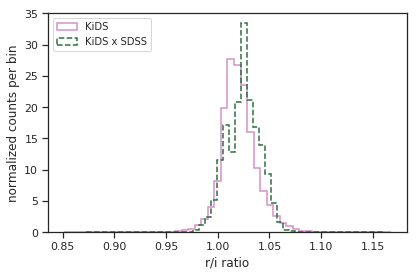

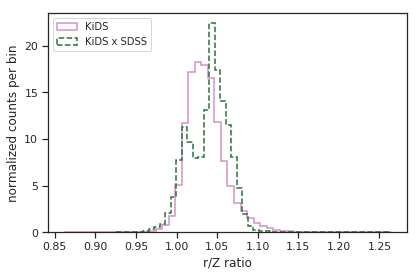

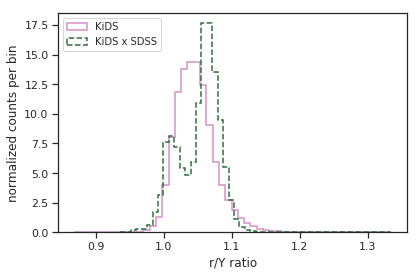

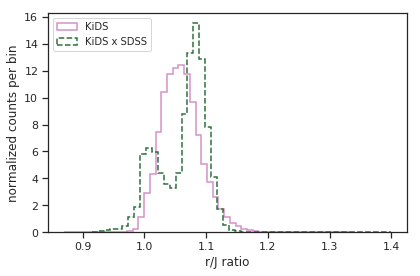

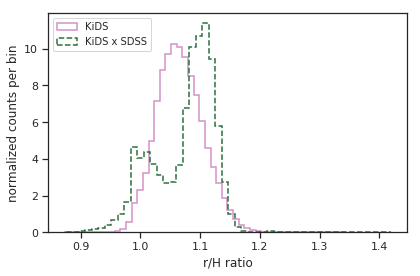

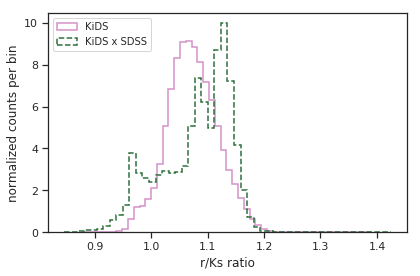

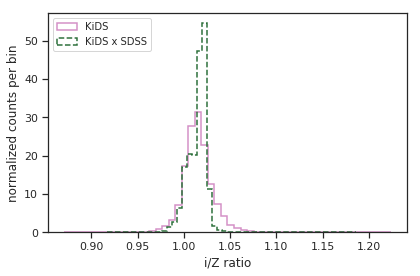

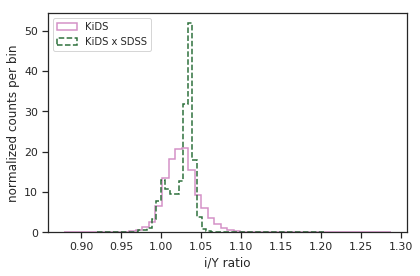

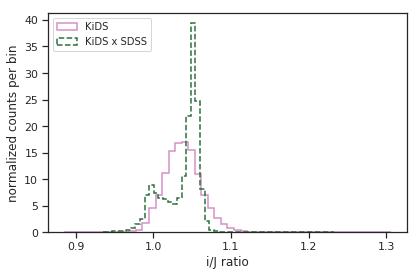

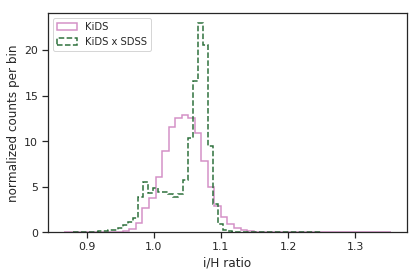

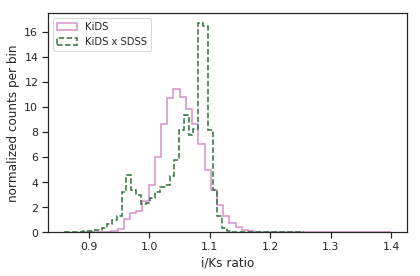

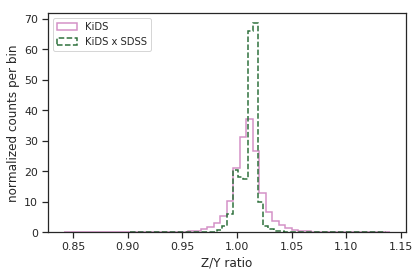

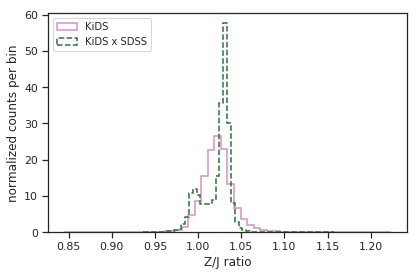

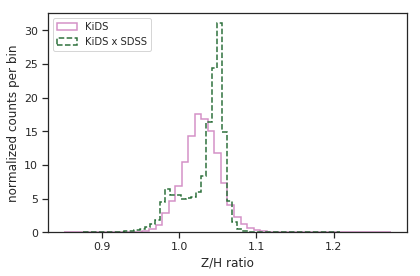

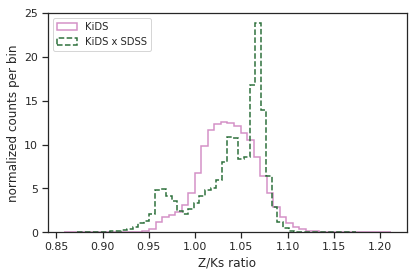

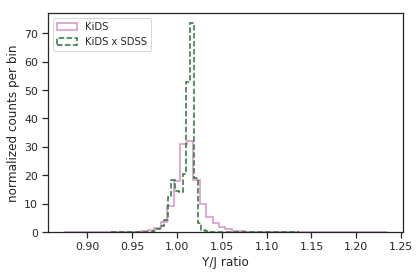

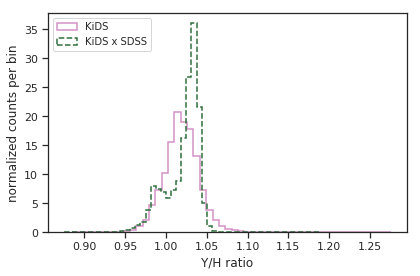

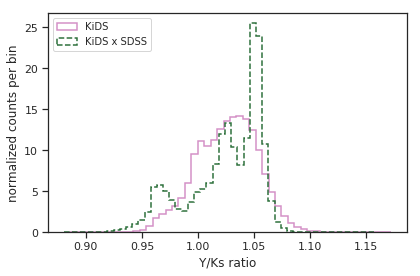

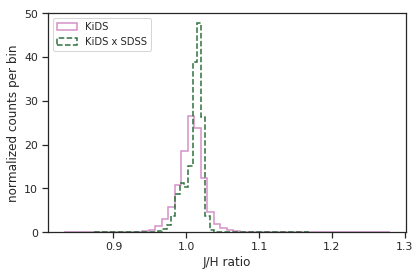

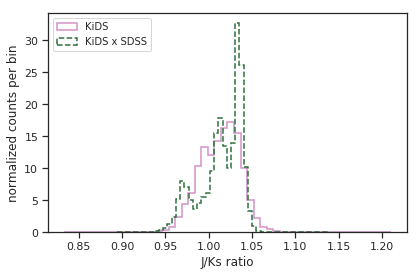

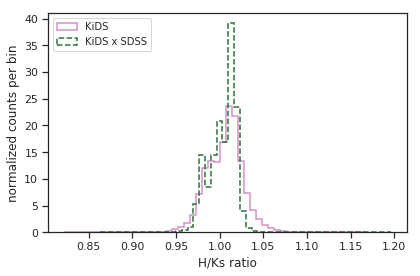

In [15]:
# Ratio histograms
data_dict = OrderedDict([('KiDS', kids), ('KiDS x SDSS', kids_x_sdss)])
plot_histograms(data_dict, RATIO_COLUMNS, legend_size=10, pretty_print_function=pretty_print_feature)

# t-SNE

In [8]:
kids_sampled = kids_merged.sample(100000, random_state=1467)

In [9]:
X = kids_sampled[FEATURES['all']]
X_scaled = MinMaxScaler().fit_transform(X)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [10]:
X_embedded = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000,
                  n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', init='random', verbose=1,
                  random_state=8934, method='barnes_hut', angle=0.5).fit_transform(X_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 3.056s...
[t-SNE] Computed neighbors for 100000 samples in 235.557s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional proba

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


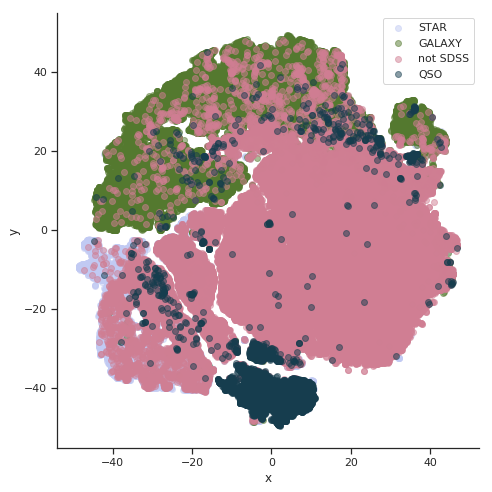

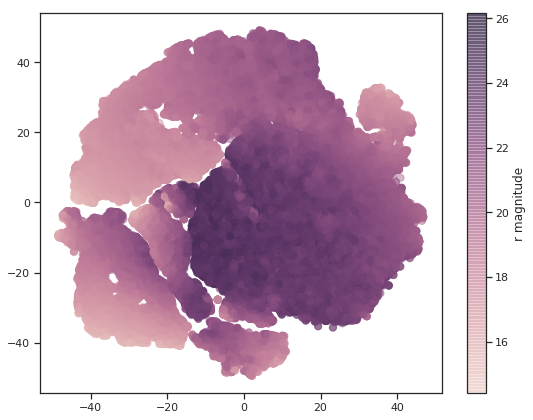

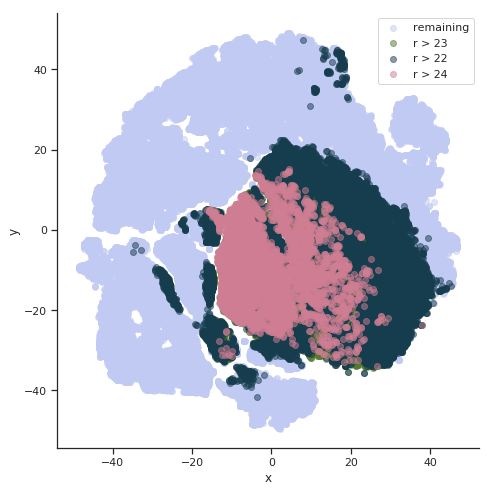

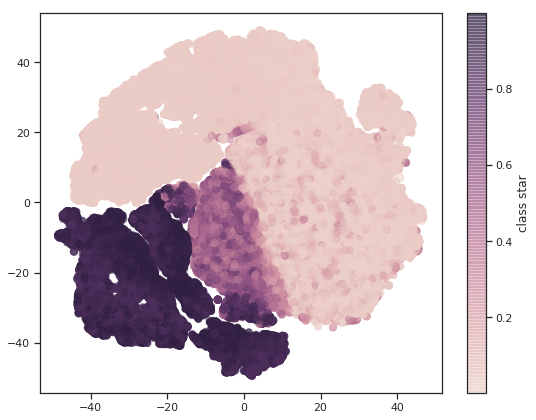

In [11]:
# Class plot
plot_embedding(X_embedded, kids_sampled['CLASS'], label='object type')

# Magnitude plot
plot_embedding(X_embedded, kids_sampled[get_mag_str('r')], label='r magnitude', is_continuous=True)

# Cut plot
plot_embedding(X_embedded, kids_sampled['cut_label'], label='data cut')

# Class star plot
plot_embedding(X_embedded, kids_sampled['CLASS_STAR'], label='class star', is_continuous=True)

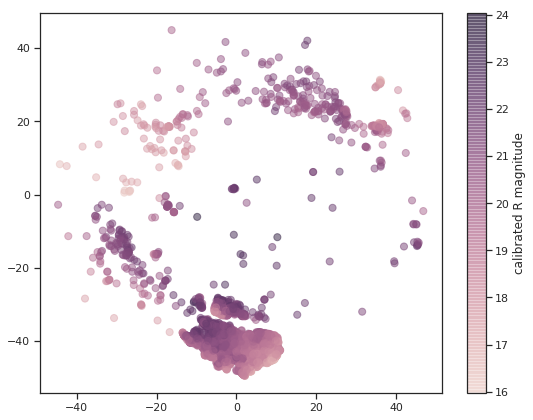

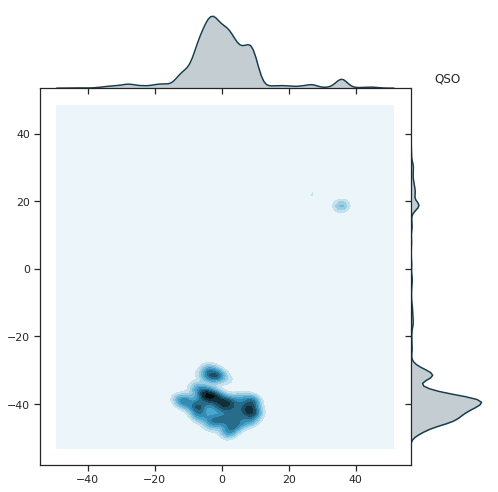

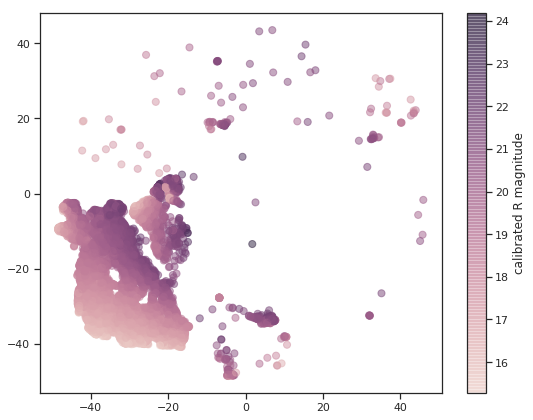

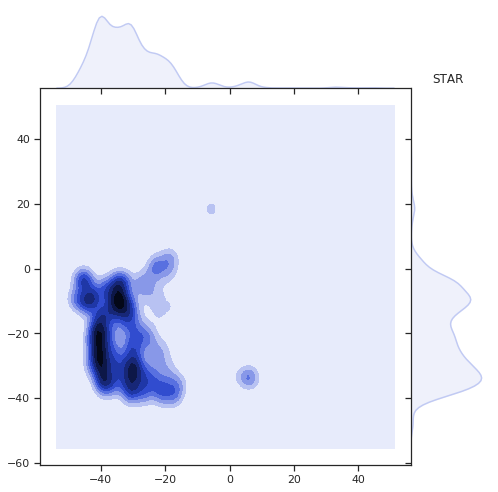

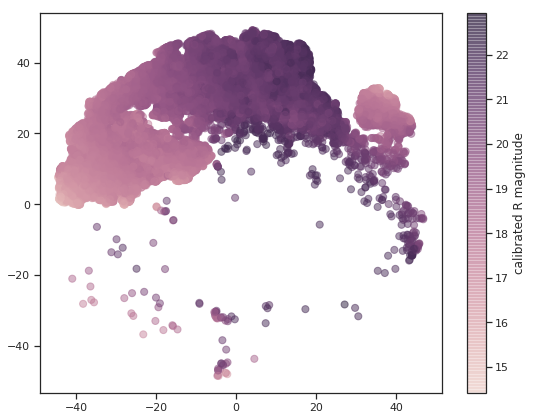

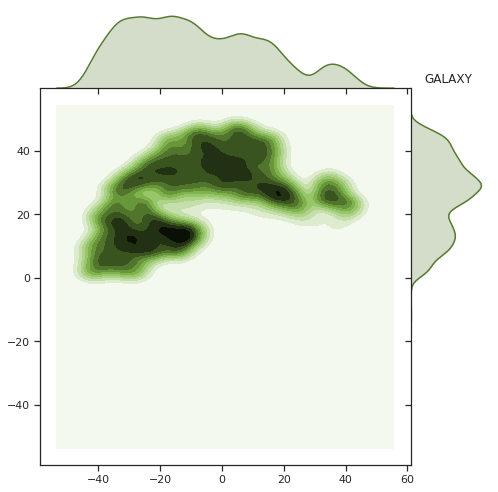

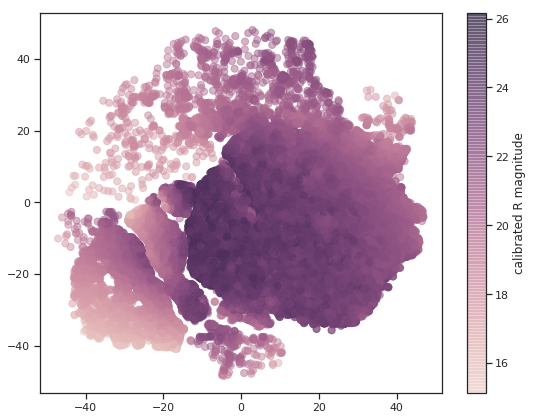

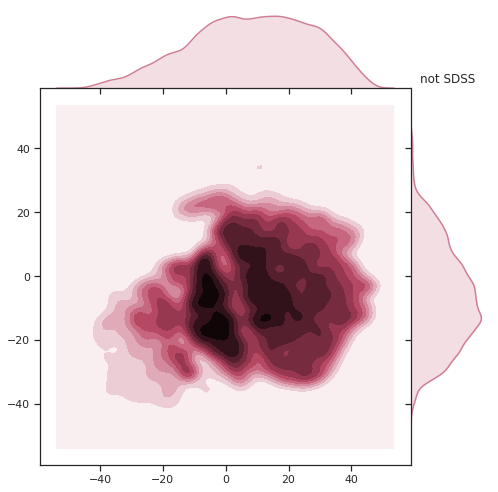

In [12]:
# Single class plots
for c in BASE_CLASSES + ['not SDSS']:
    idx_class = (kids_sampled['CLASS'] == c)
    
    plot_embedding(X_embedded[idx_class], kids_sampled.loc[idx_class, get_mag_str('r')],
                   label='calibrated R magnitude', is_continuous=True)
    
    sns.jointplot(X_embedded[idx_class][:, 0], X_embedded[idx_class][:, 1], kind='kde', height=7, space=0,
                 color=CUSTOM_COLORS[c])
    
    plt.title(c)